# HOL2148 - Watson Knowledge Catalog

## Introduction

In this notebook we programmatically publish datasets into a catalog in Watson Knowledge Catalog. We map business terms to the dataset column headers. The business terms and their mappings are specified in a csv file included with the project. 

A user can also assign business terms to column headers manually or by using the Data Discovery capability within Cloud Pak for Data but this is not part of the lab.

## 1. Collecting the assets in the project

In order to publish assets to the catalog we first have to collect them in this project. We will add 3 connections and 6 tables to the project and all of them will be published to the catalog later.

1. Open a new browser tab to add the assets by right-clicking on the project name and choosing "open in new tab". <br>
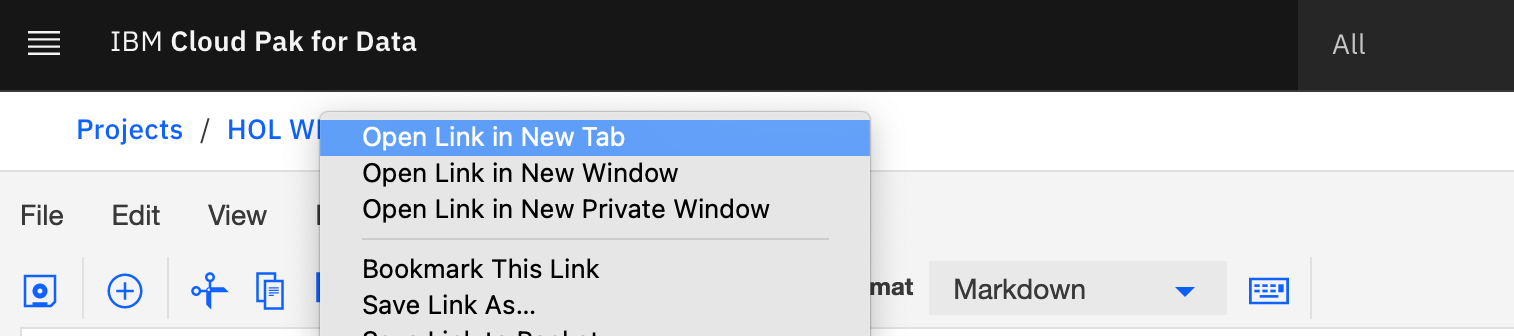

2. In this new tab you should see the project. Select the "Assets" tab and click on "Add to project" and then "Connection".<br>
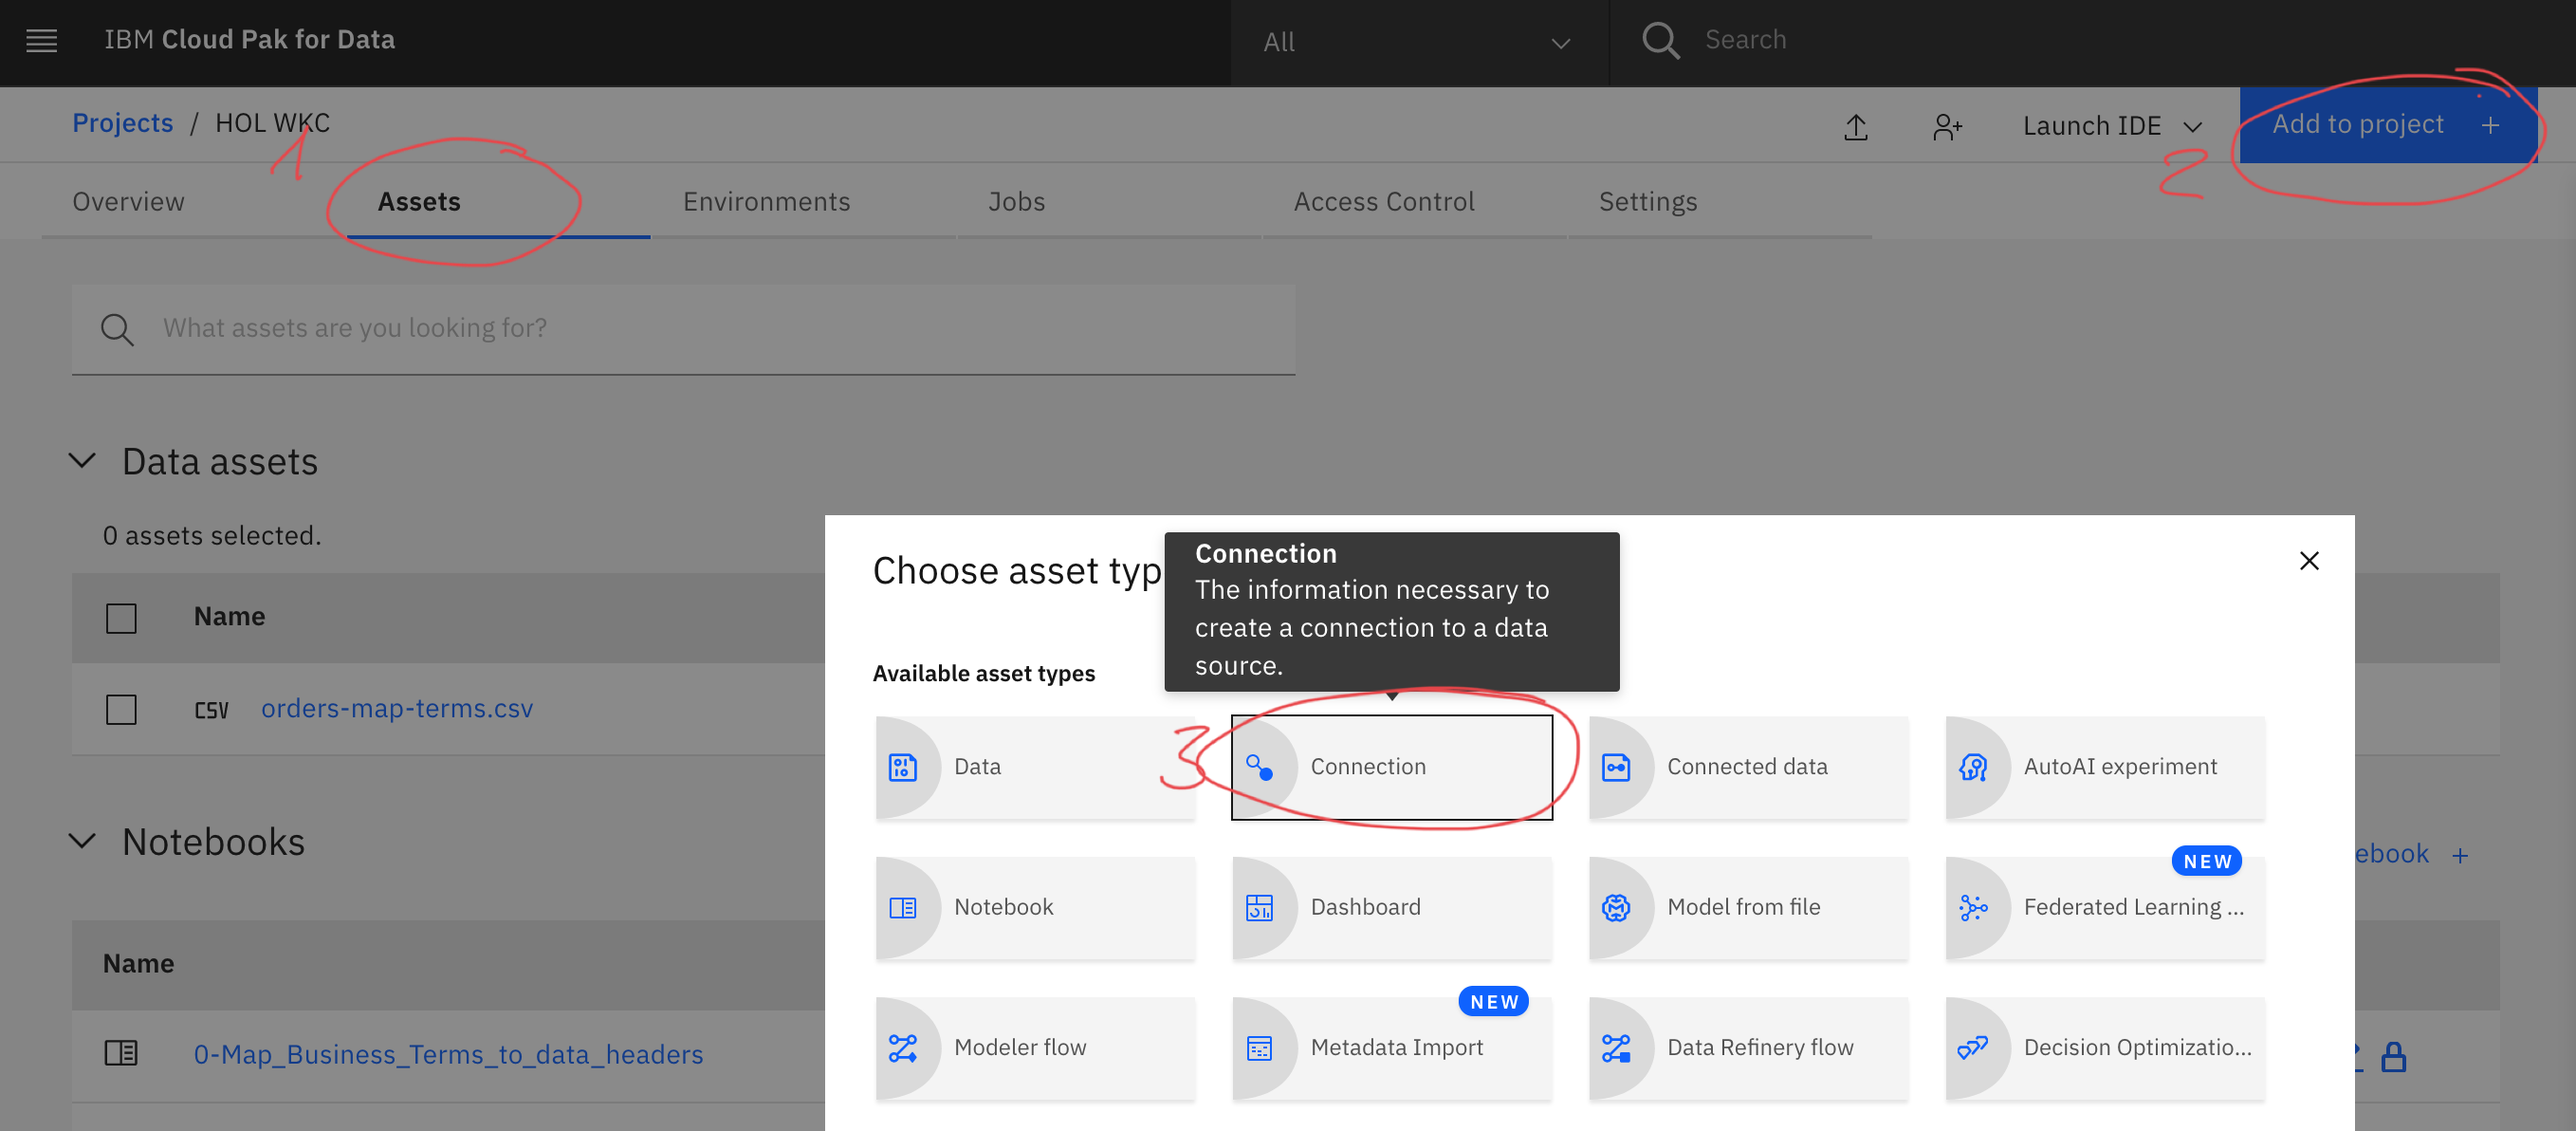


3. Click tab "From platform" and select the connection "DV"<br>
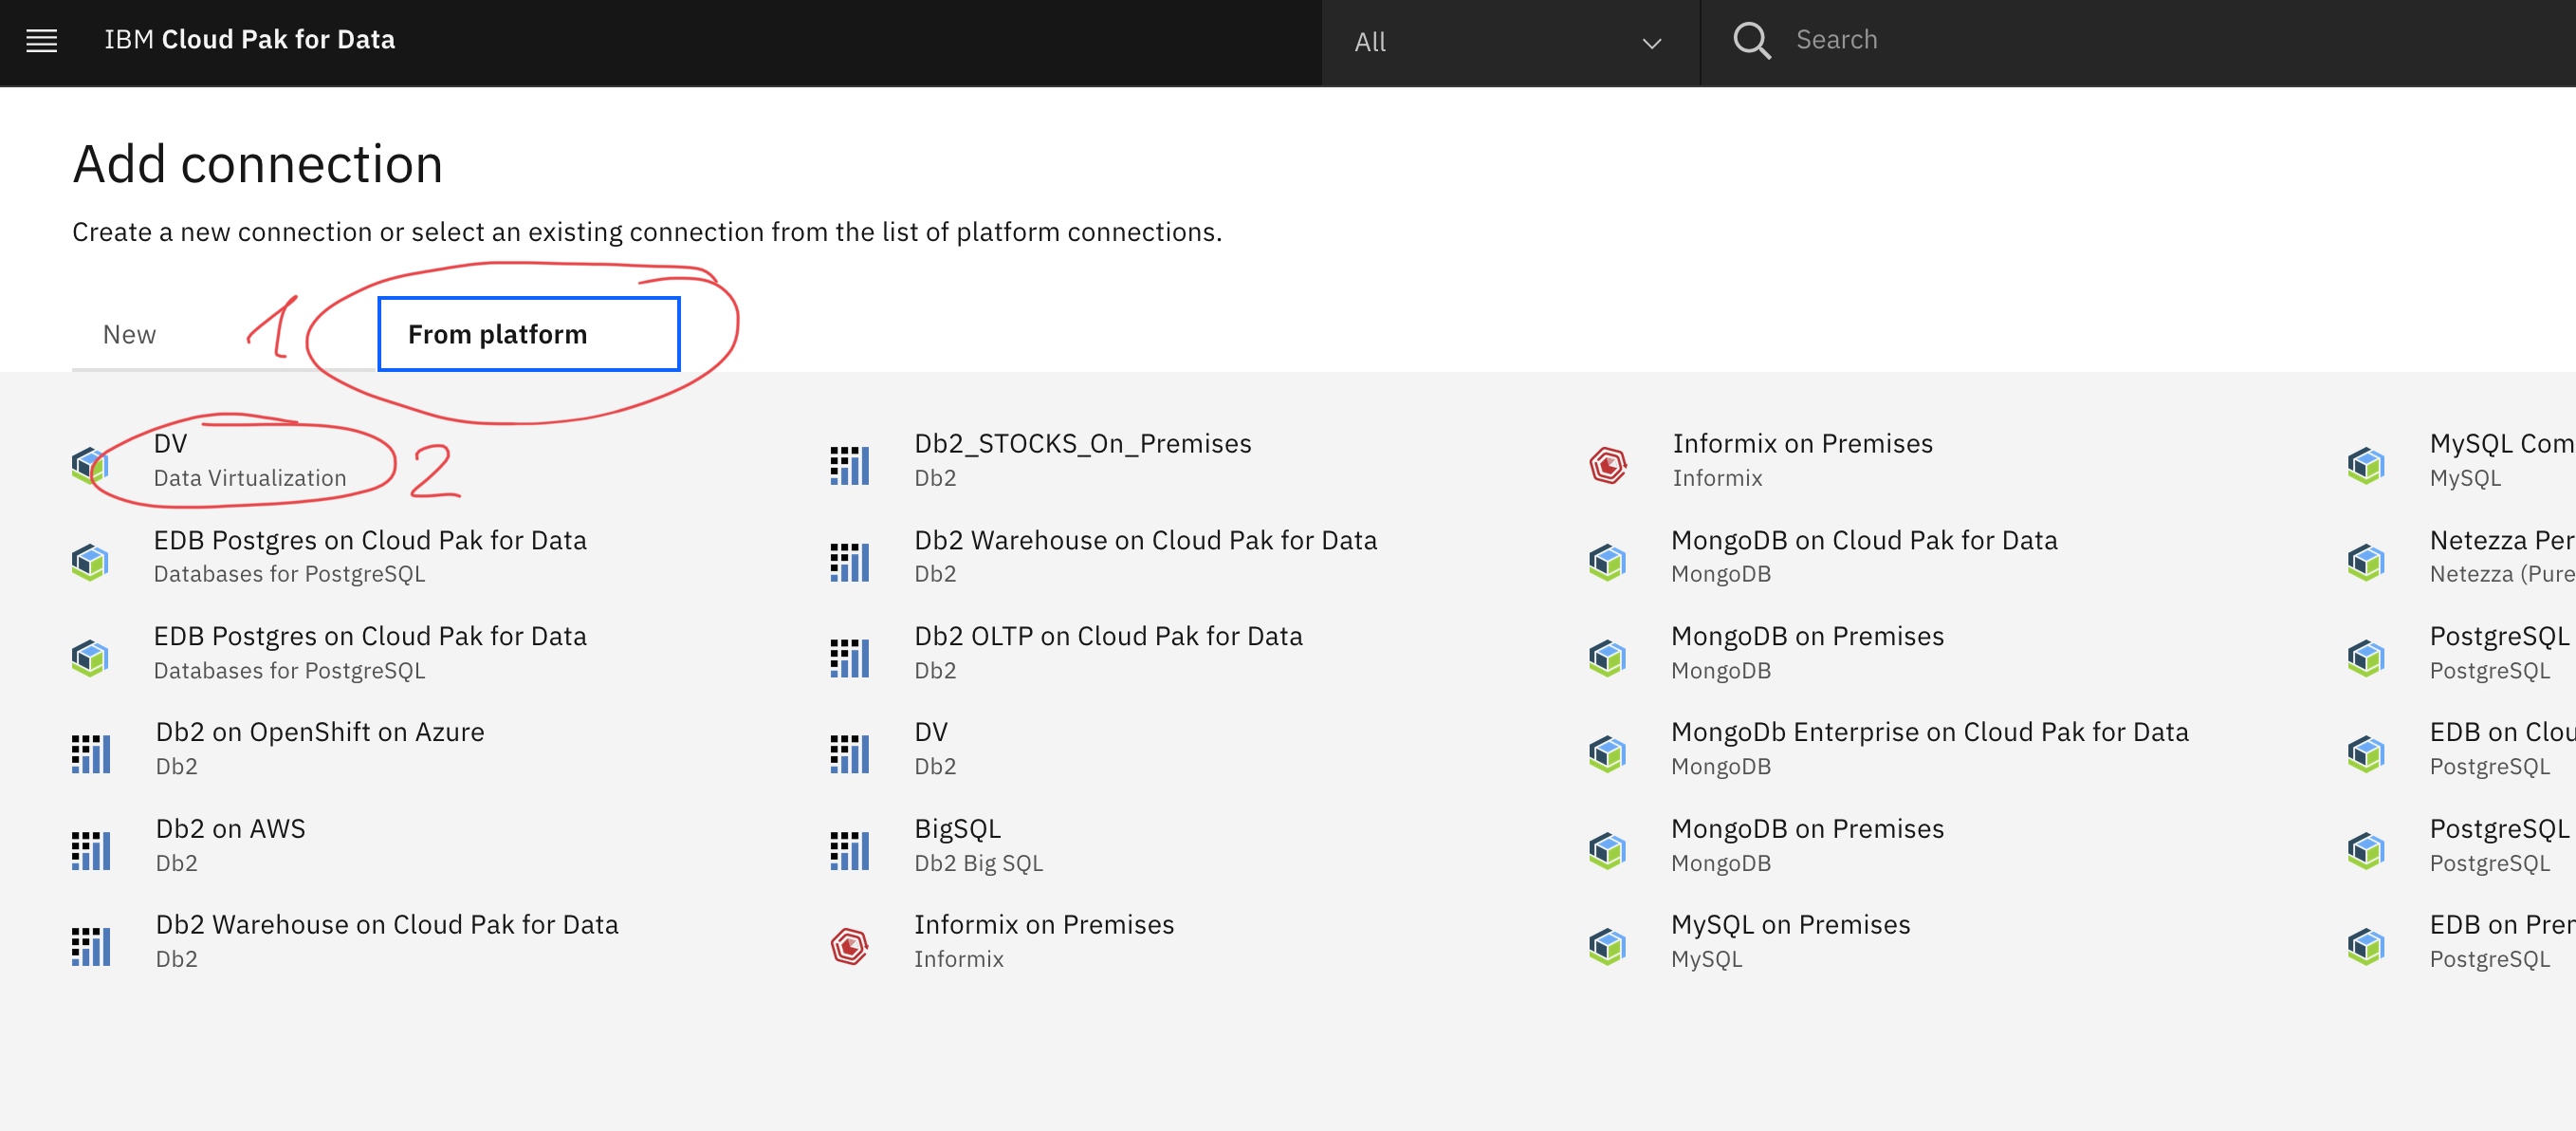

4. The platform connections are just templates and you have to enter your user and password in the boxes below. Click "Test" on bottom right. This should test the connection and if successful a green bar should appear. Now click "Add". <br>
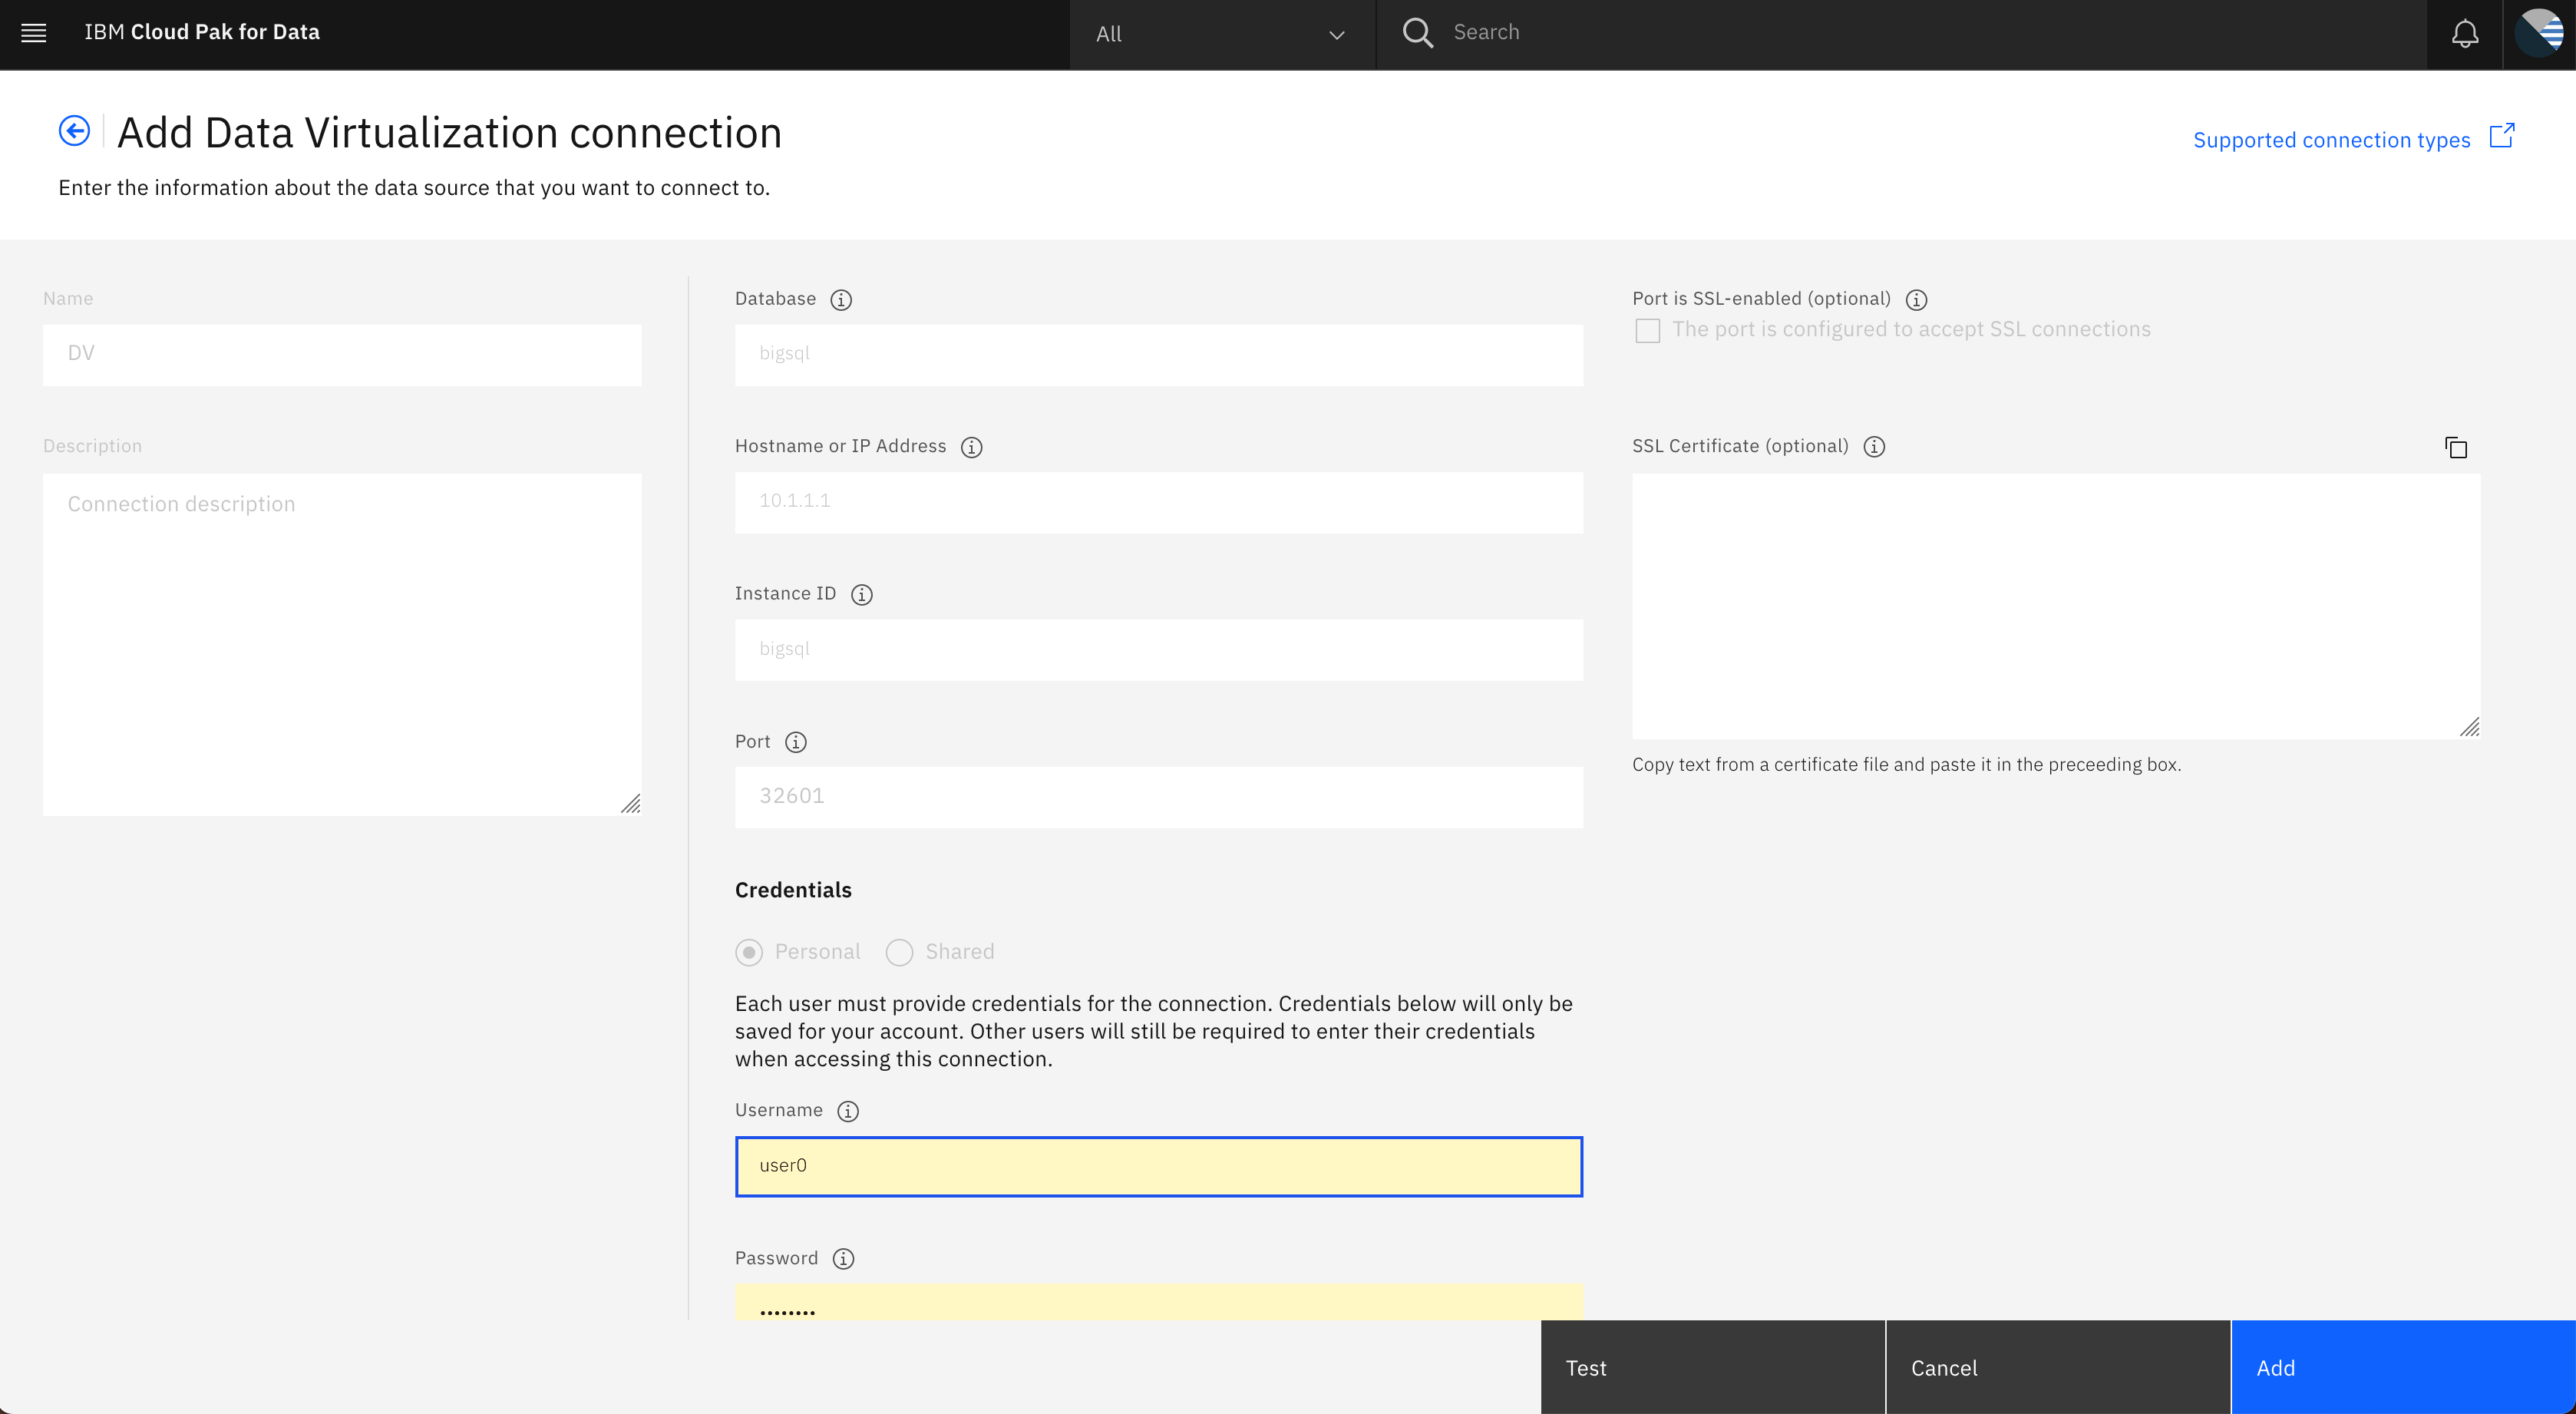

5. Repeat the steps also for platform connections "Db2 BigSQL" and "Db2 Warehouse on Cloud Pak for Data". You should have this 3 connections in your project listed under "Data Assets".<br>
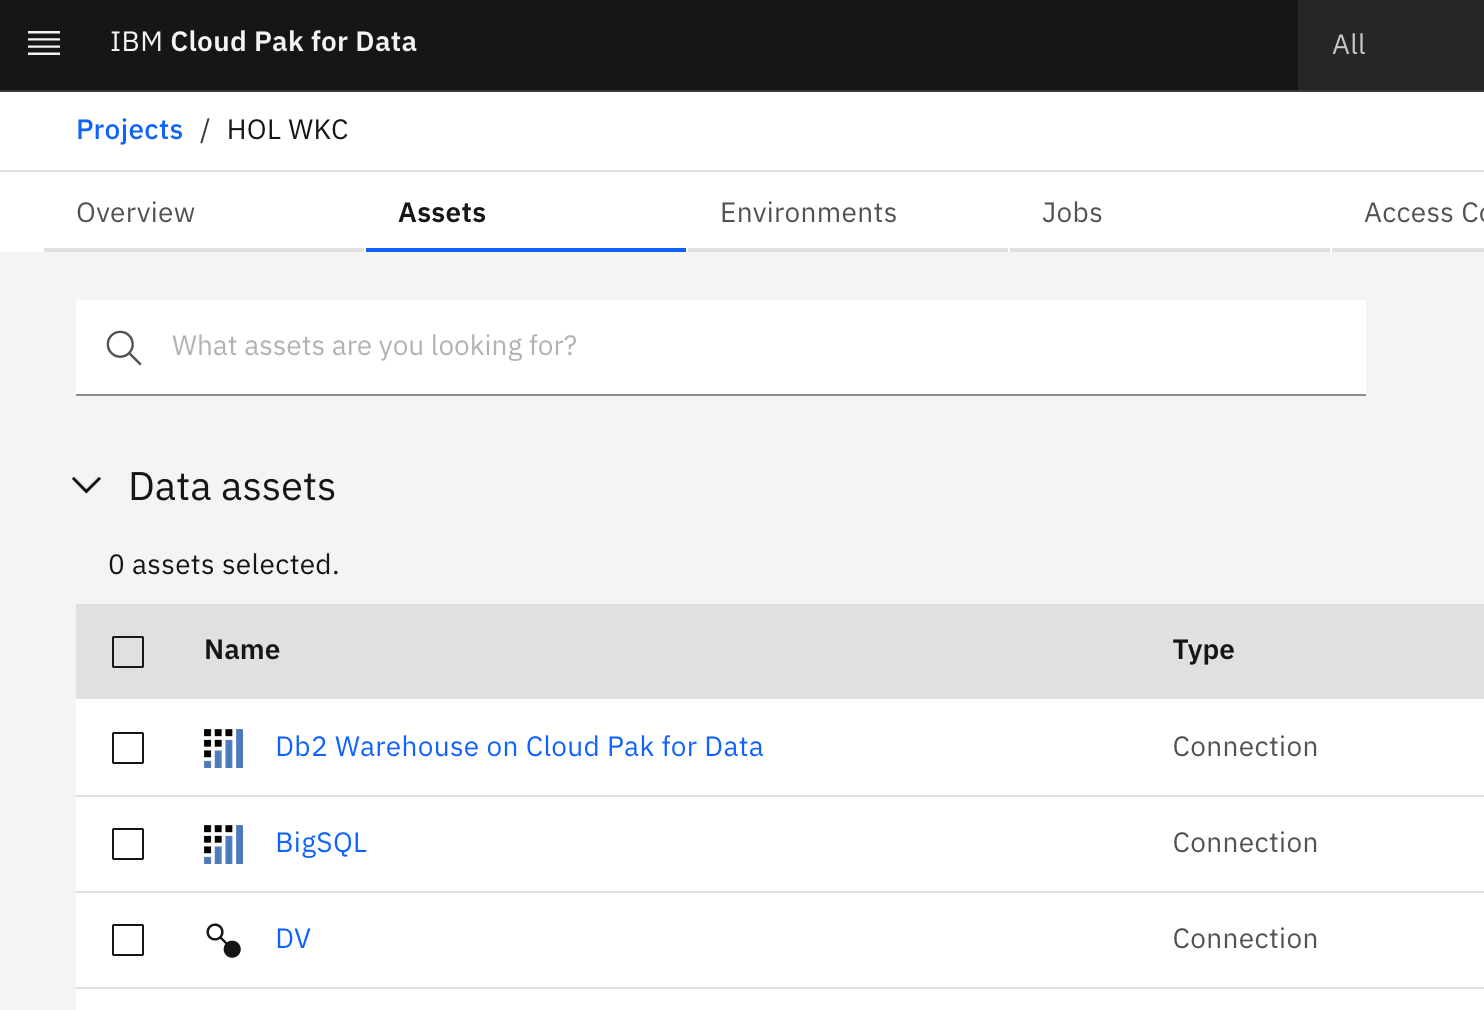

7. Now we add the tables by again clicking "Add to project" and choosing "Connected data". Click on "Select source".<br>
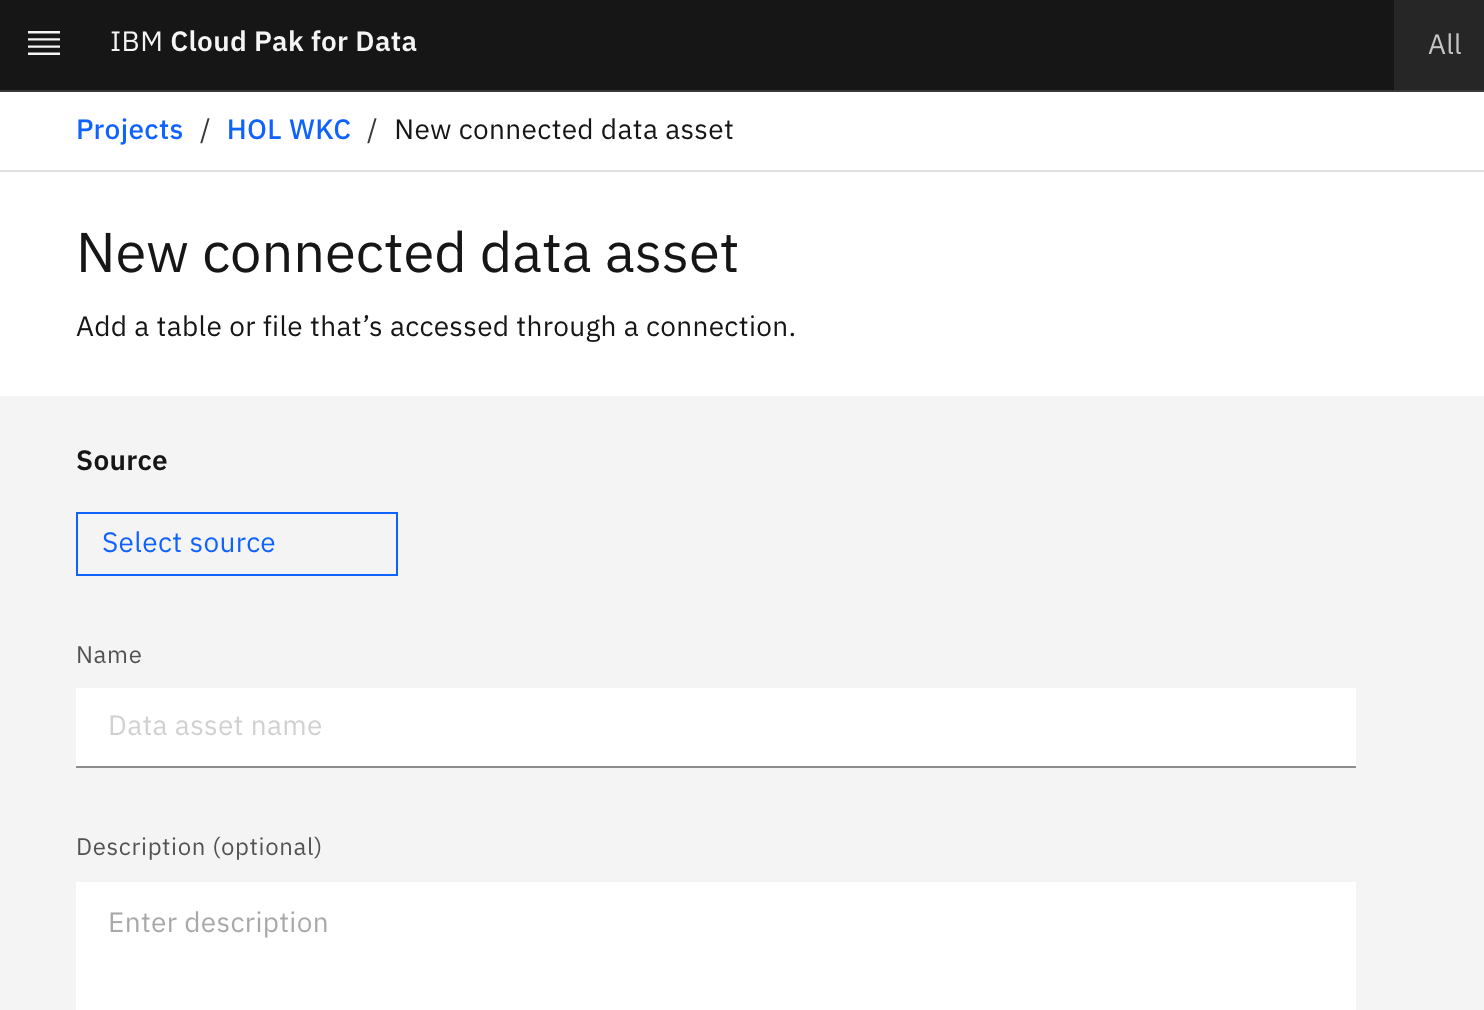


8. Choose "Db2 Warehouse on Cloud Pak for Data" as Connection, "USER" as schema and "CUSTOMER" as table and click "Select"<br>
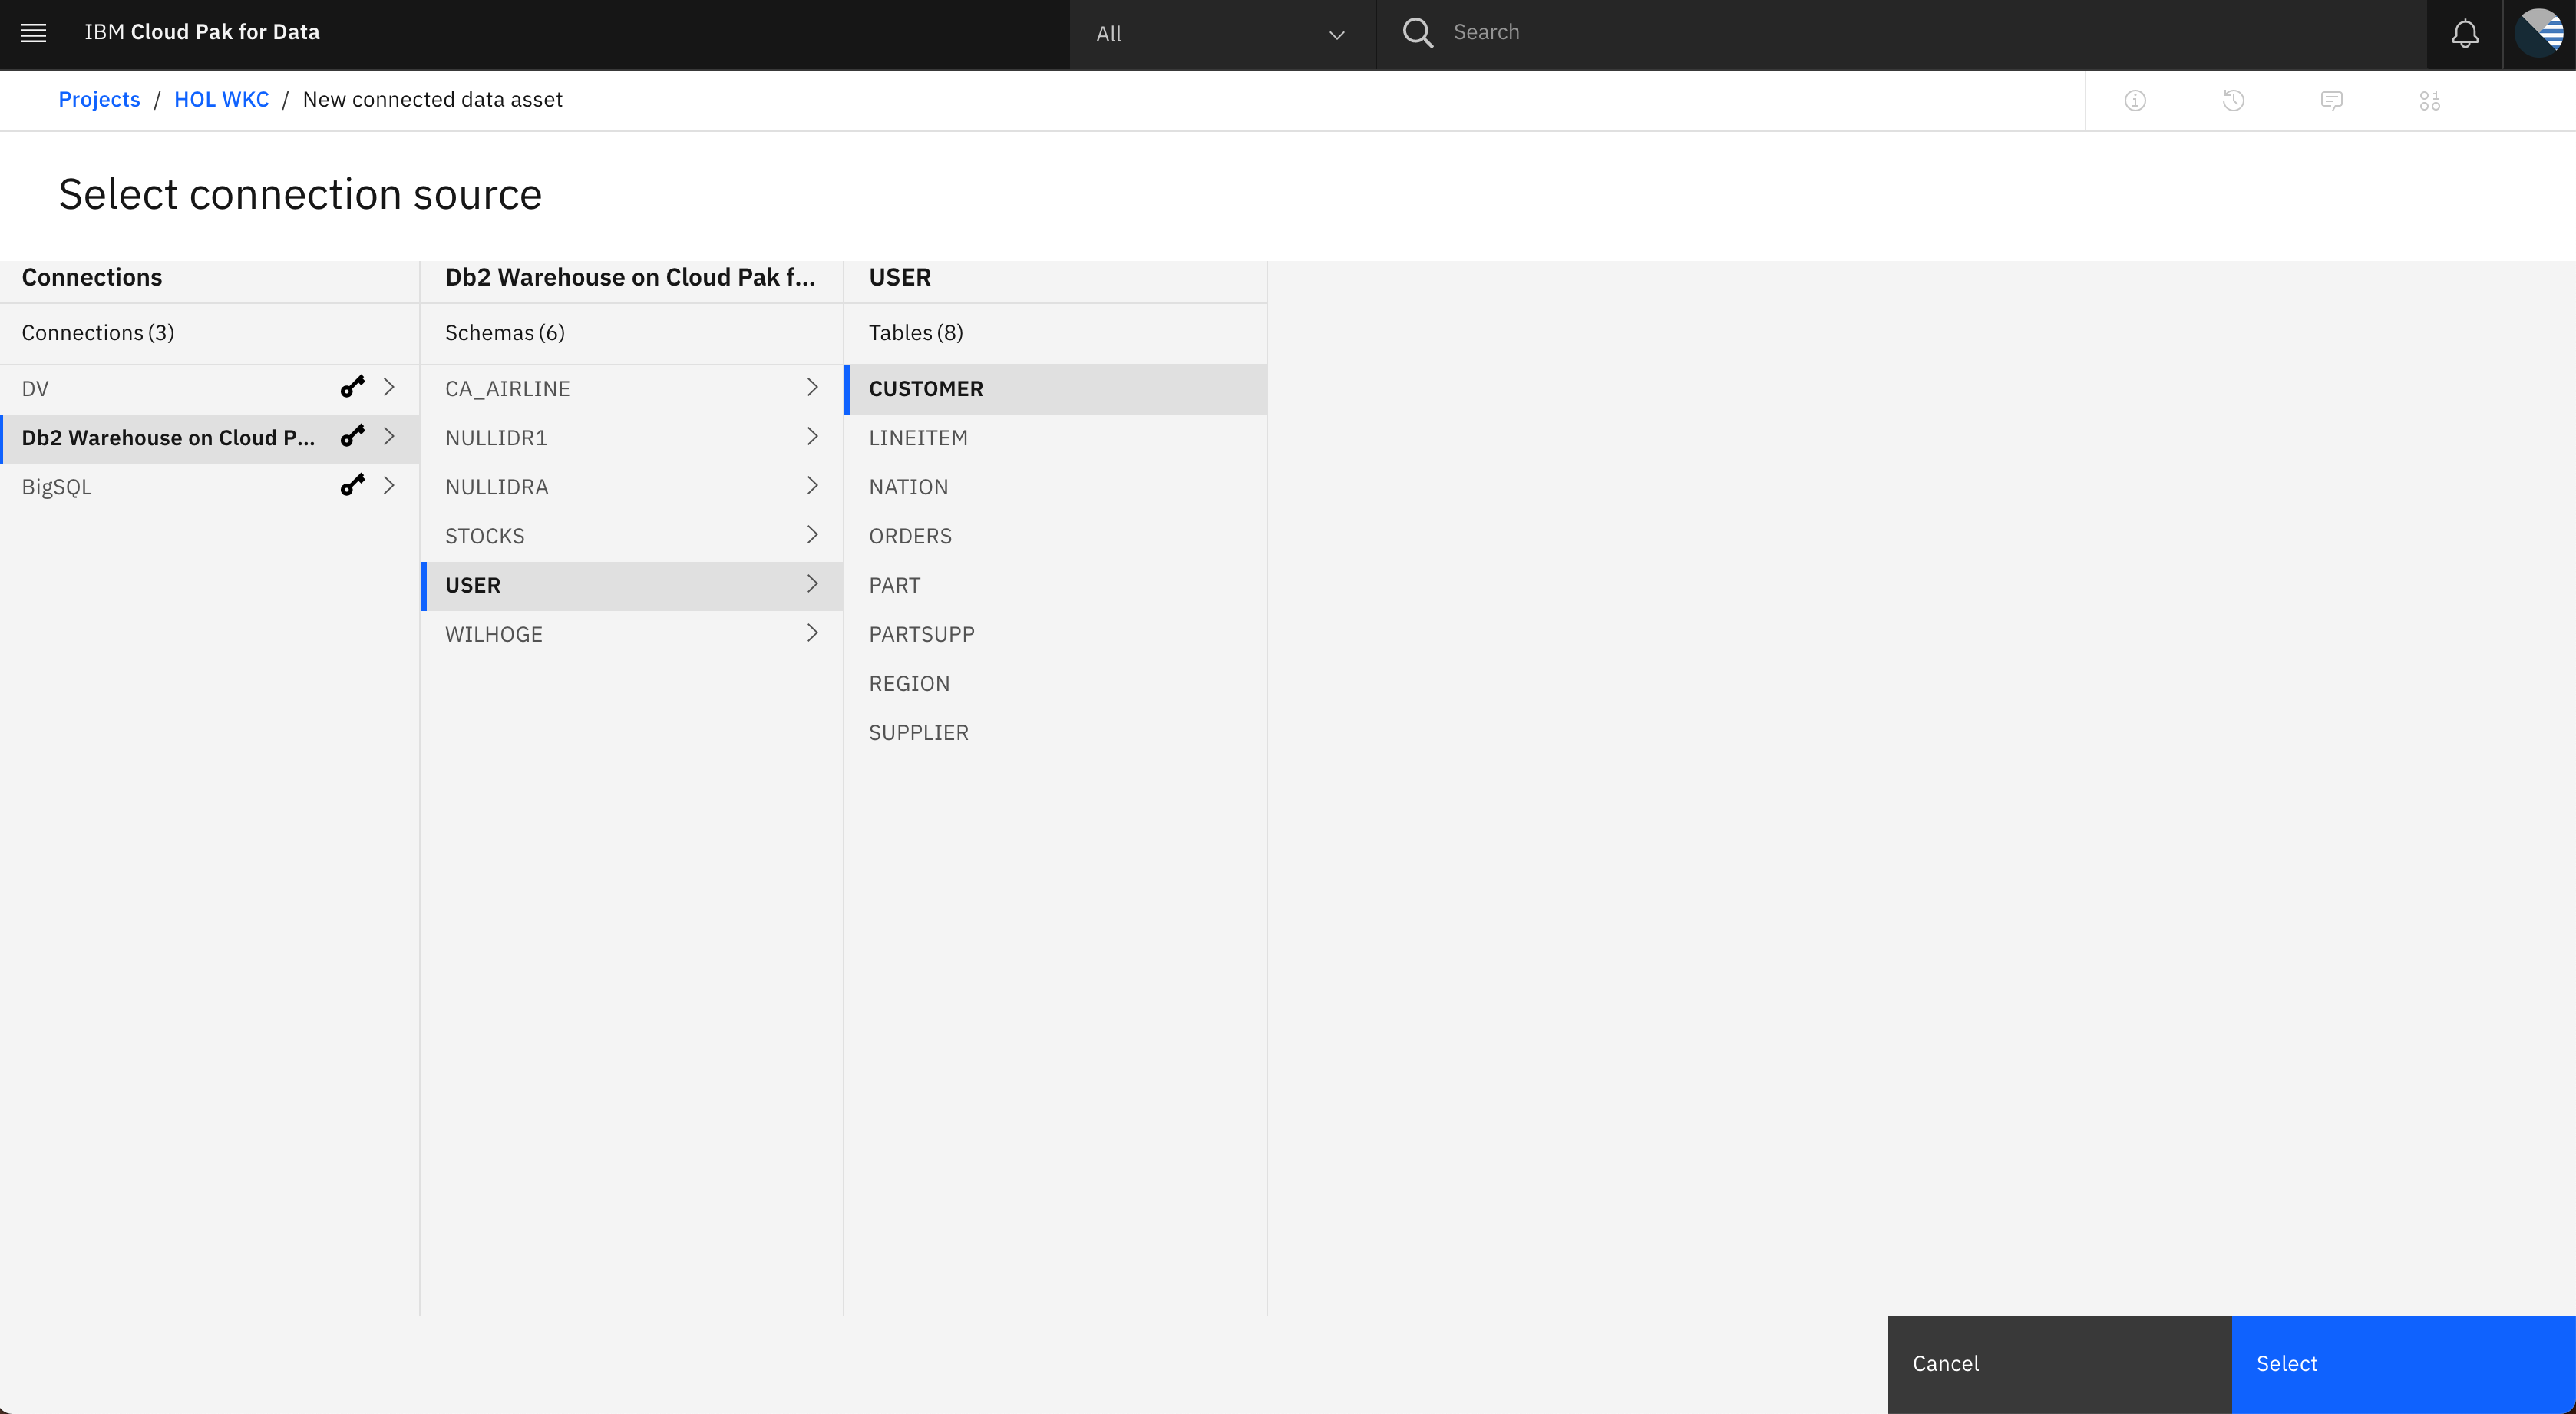

9. Give the data asset the name "CUSTOMER" and click "Create".<br>
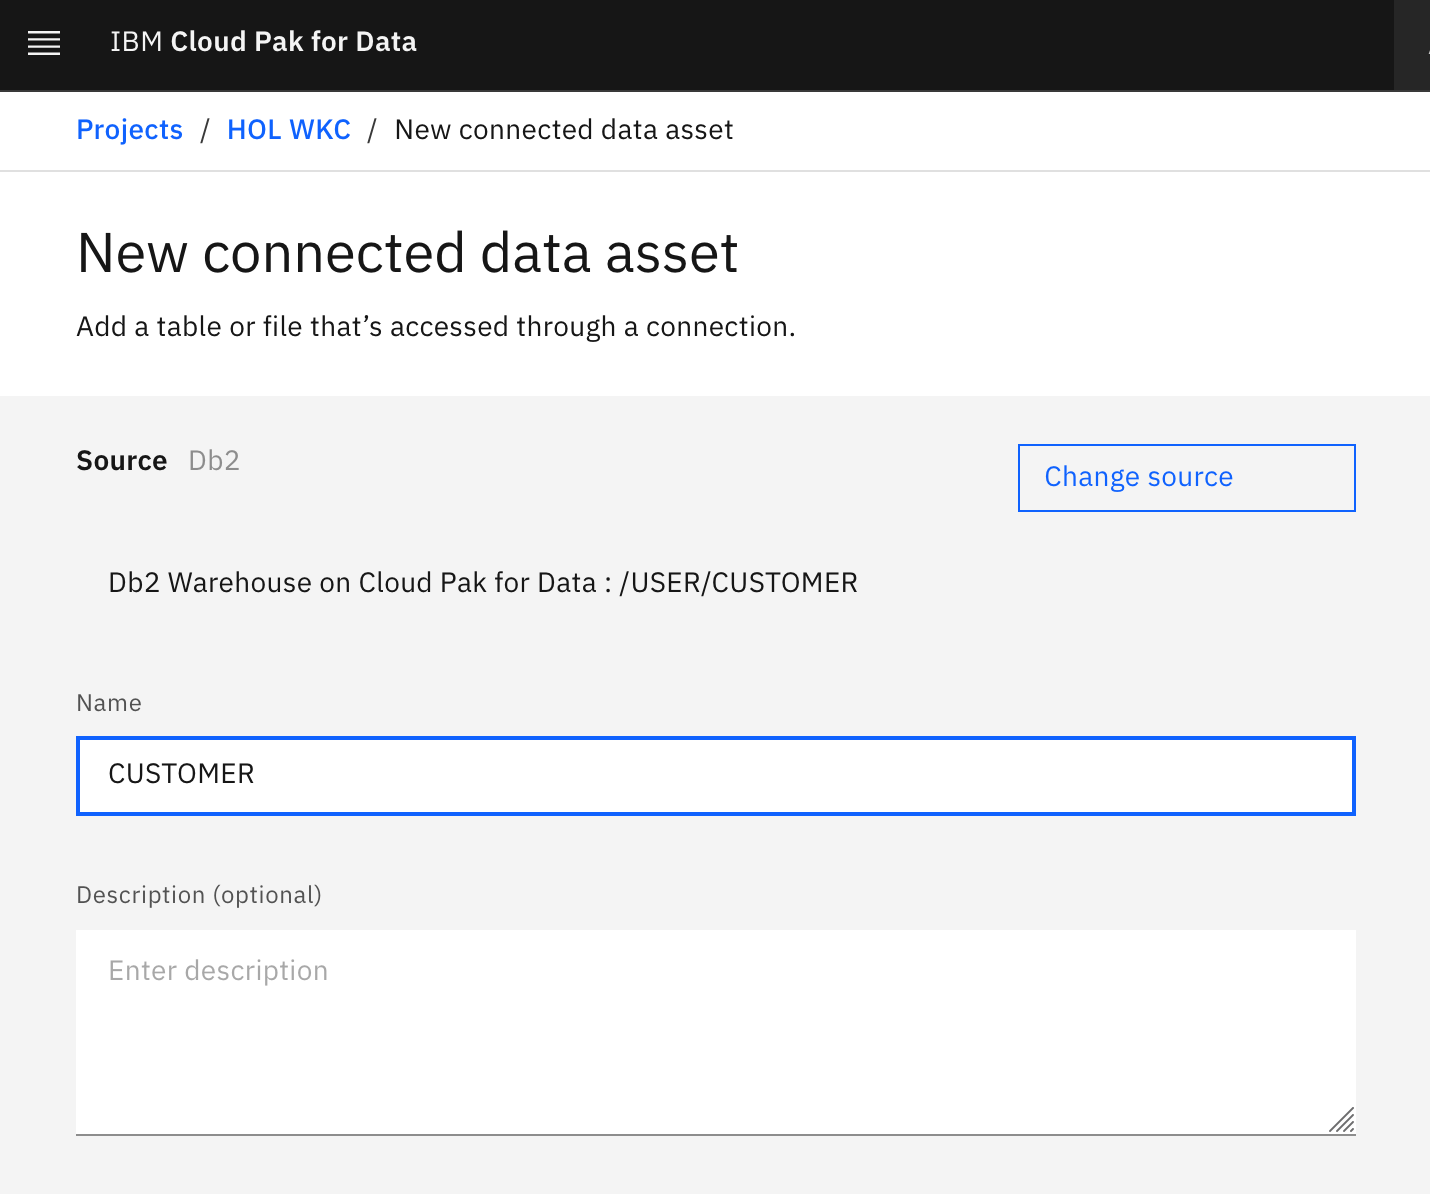

10. Repeat the steps for 
    - "Db2 Warehouse on Cloud Pak for Data" > "USER" > LINEITEM
    - "BigSQL" > "USER" > "ORDERS"
    - "BigSQL" > "USER" > "REGION"
    - "DV" > "USER" > "PART"
    - "DV" > "USER" > "PARTSUPP"

You should now see these 3 connections and 6 tables now in your asset view of the project.

## 2. Show catalog in Watson Knowledge Catalog

The catalog used in this lab is already created. To show the catalog click the hamburger menu on the top left, open the "Catalog" section (if no already opened), right click on "All catalogs" and open the link in a new browser tab. <br>
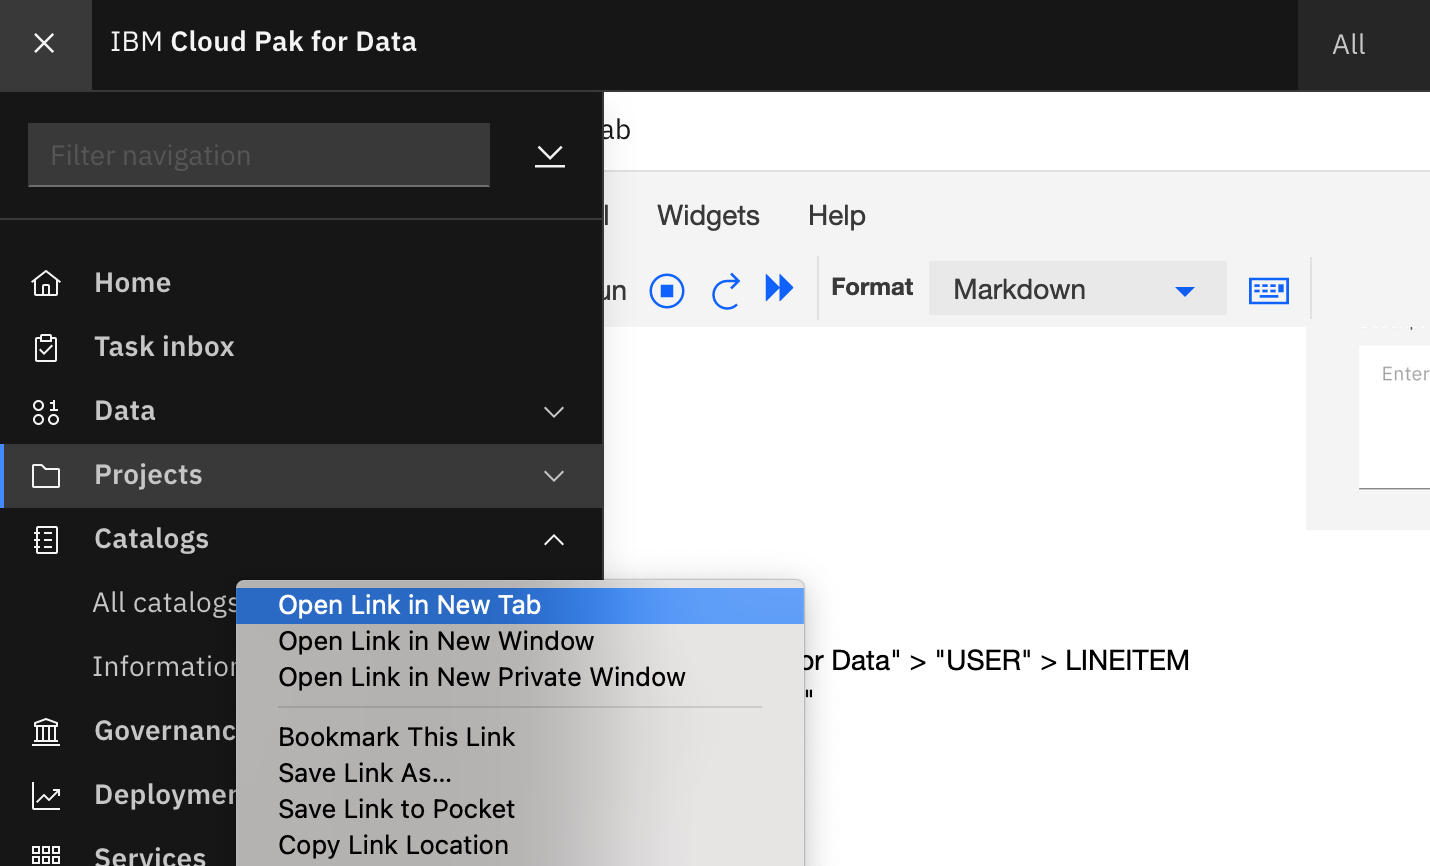

You should see two catalogs. The platform asset catalog is a special catalog not interesting in this lab. The userx catalog is used in this lab and you should open it by clicking on its name.<br>
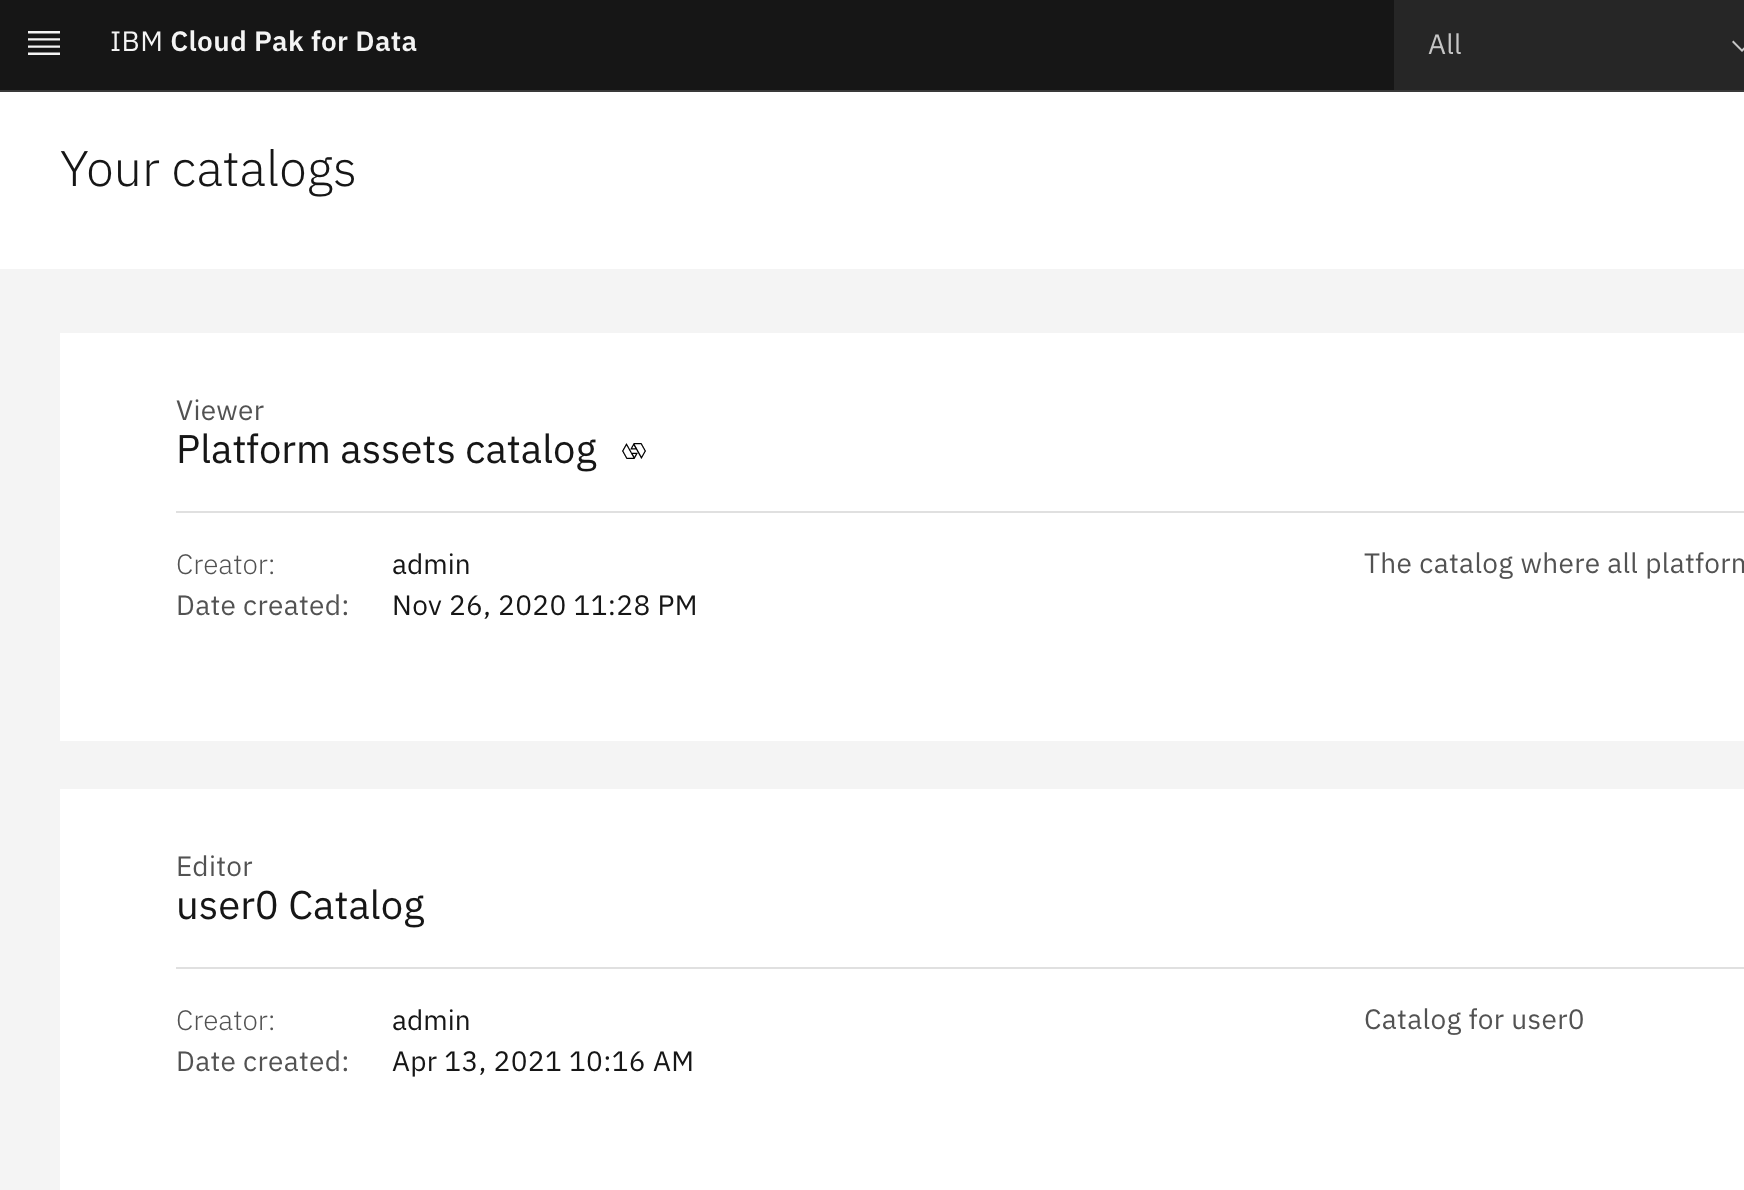


Initially the catalog is empty. <br>
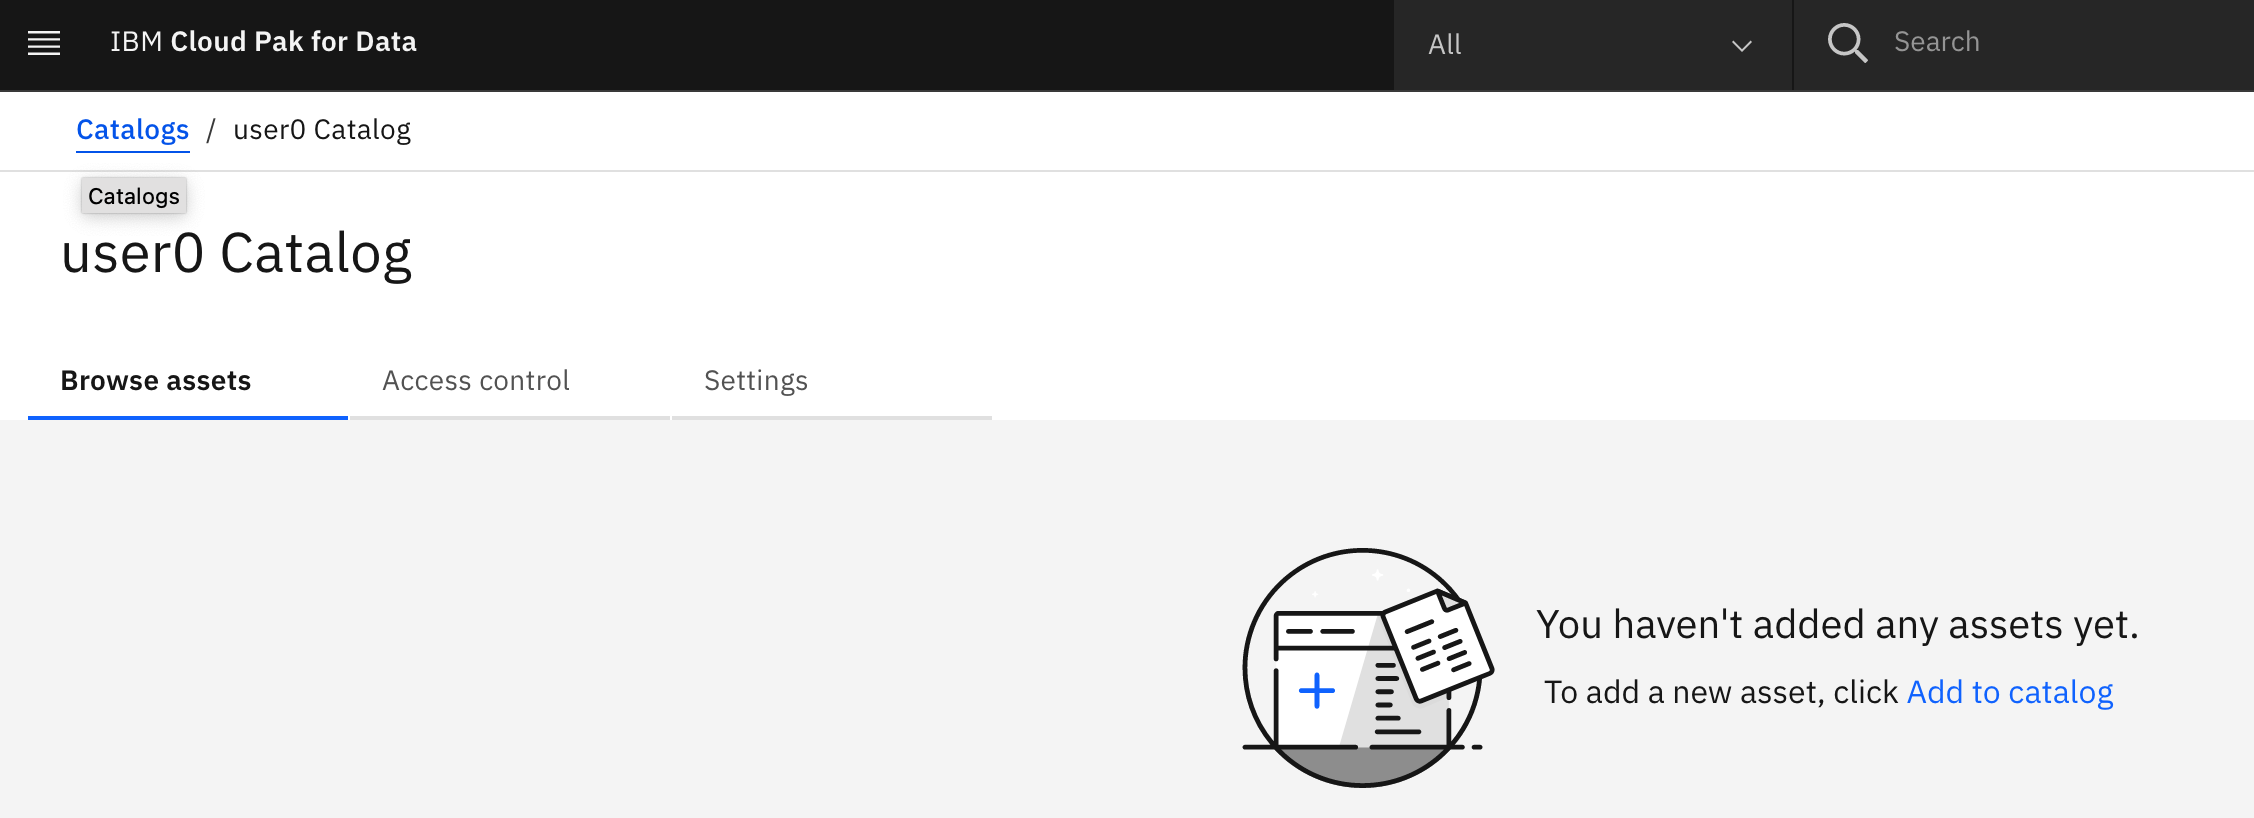


## 3. Publish assets to the catalog and assign business terms to columns

The publishing of assets to the catalog and the assignment of bussiness term can be done through the GUI. In this lab we will do this via API calls to show that also a programmatical approach is possible. 

This notebook has a number of code cells below that you should run by pressing the "Run" botton above. To do so place your cursor in a cell and press "Run". The cell executes and the output of the program snippet is shown below the cell. The cursor moves automatically to the next cell.

1. We start with the first code cell that loads the necessary libraries into the notebook. 

In [11]:
# imports and settings for the rest APIs interactions with WKC

import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import json
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from pandas.io.json import json_normalize
import pandas as pd
import os
from project_lib import Project
project = Project()

print("Libraries loaded")

Libraries loaded


2. To connect to the WKC api we have to define some values. You don't have to change the "host", but you should change the values for "uname" and "pword" to your user and password. The catalog name is calculated from the username.

    Change the values below and run the cell

In [12]:
# connection info for catalog

host = 'https://cp4d-cpd-cp4d.apps.openshift-skytap-nfs-lb.ibm.com'
uname = 'user0'
pword = 'password'
catalog_name = uname + ' Catalog'

print("Selected catalog: ", catalog_name)

Selected catalog:  user0 Catalog


3. We also create additional variables. The user does not need to change the code cell below if all assets above have been added to the project. You can adjust the lists if necessary.

    - **category_name :** Name of the business term category corresponding to the project.
    - **terms_file :** Name of the csv file containing the list of mappings between column headers and business terms.
    - **connection_to_publish :** Name of the connections will be published into the catalog.    
    - **table_to_publish :** Name of the connections will be published into the catalog and for which we map business terms.

In [14]:
# business term and asset infos

category_name = "Orders category"
terms_file = "orders-map-terms.csv" 

connection_to_publish = ['Db2 Warehouse on Cloud Pak for Data','BigSQL','DV']
table_to_publish = ['CUSTOMER','PART','REGION','LINEITEM','PARTSUPP','ORDERS']

print("Connections: ", connection_to_publish, " Tables: ", table_to_publish)

Connections:  ['Db2 Warehouse on Cloud Pak for Data', 'BigSQL', 'DV']  Tables:  ['CUSTOMER', 'PART', 'REGION', 'LINEITEM', 'PARTSUPP', 'ORDERS']


4. Authenticate, generate a token and validate the token on this cluster.

In [15]:
# Creates requests session and stores in `s`
s = requests.Session()

# Authenticate the cluster with specified username and password and store the access token for future reference
wkcURLauth=host+"/icp4d-api/v1/authorize"

# Payload with username and password
payload={
    "username": uname,
    "password": pword
}

# Header with json format
headers = {
    'Content-Type': "application/json",
    'cache-control': "no-cache"
    }

# Creates a post request with the endpoints specified above in the wkcURLauth variable with payload and header.
# When successfully authenticated token is stored in a variable as below
# catch error if the specified url is not correct
try:
    res = s.post(wkcURLauth,headers=headers,json=payload, verify=False)
except:
    print("The below error has occurred. Please check that the hostname entered is correct.")
    raise
    
if res.status_code == 200:
    print("Authentication Successul")
    accessToken=json.loads(res.text)['token']
else:
    print('The below error has occurred. Please check entered username and password are correct.')
    raise ValueError(res.text)

Authentication Successul


5. Business terms are organized in categories. The cell below fetches all the categories in the system and determines the category ID for the "Orders Category", that holds the business terms for this lab.

In [19]:
search_url=host+"/v3/search"
try:
    headers = {
        'Content-Type': "application/json",
        'Authorization': "Bearer "+accessToken,
        'Cache-Control': "no-cache",
        'Connection': "keep-alive"
        }
    
    search_body = {
        "size": 1000,
        "_source": ["artifact_id","metadata.name"],
       "query": {    
               "match": {"metadata.artifact_type": "category"}
       }
    }
    parent_cat = s.post(search_url, verify=False,  json=search_body, headers=headers)

    if parent_cat.status_code == 200:
        category=json.loads(parent_cat.text)
        for i in category['rows']:
            
            if i['metadata']['name']== category_name:
                exists_category=True
                category_id=i['artifact_id'] 
                print("Category ",category_name,"has the ID",category_id)

except:
    print("The below error has occurred. " + "Please ensure that category, '" + category_name + "', exists.")
    raise ValueError(parent_cat.text)

Category  Orders category has the ID 03a57c4b-a4a9-4b3f-9612-a60dfcd9558a


6. Load the business terms and their IDs from the category and store them in a dataframe.

In [20]:
# Create a payload for the post request, This payload contains information on size of the terms, source, category and subcategory ids
payload={"size":300,"from":0,"_source":["artifact_id","metadata.artifact_type","metadata.name","metadata.description","categories","entity.artifacts"],"query":{"bool":{"filter":{"bool":{"minimum_should_match":1,"should":[{"term":{"categories.primary_category_id":category_id}},{"term":{"categories.secondary_category_ids":category_id}}],"must_not":{"terms":{"metadata.artifact_type":["category"]}}}}}}}
# create a post request with above payload 
wf=s.post(host+"/v3/search",headers=headers,json=payload,verify=False)
# it will return all the terms , load these terms into a dataframe
wf_json=json.loads(wf.text)['rows']
df_terms=pd.json_normalize(wf_json)

df_terms=df_terms[['entity.artifacts.global_id','metadata.name']]
print("List of business terms:")
df_terms.head()

List of business terms:


,entity.artifacts.global_id,metadata.name
0,5d2d5419-0032-4c64-90e2-ce68c6997bb5_8ffe1e39-...,Supplier key
1,5d2d5419-0032-4c64-90e2-ce68c6997bb5_6cb27e44-...,Order date
2,5d2d5419-0032-4c64-90e2-ce68c6997bb5_76b2af90-...,Part size
3,5d2d5419-0032-4c64-90e2-ce68c6997bb5_e15242a8-...,Linenumber commit date
4,5d2d5419-0032-4c64-90e2-ce68c6997bb5_bc9321a8-...,Order ship priority


7. The cell below determines the catalog ID for the target catalog.

In [21]:
## Get catalog that created and its id by providing name of the catalog created, wich should be same as the one entered in the previous cells
catalog_endpoint=host+"/v2/catalogs"
# Create new header for the requests
headers = {
'Content-Type': "application/json",
'Authorization': "Bearer "+accessToken

}

# endpoint to get all the catalogs 
get_catalog=s.get(catalog_endpoint,verify=False, headers=headers)


## Find the catalog created with specific name and store name and id of it into catalog_name and catalog_id respectively
try:
    get_catalog_json=json.loads(get_catalog.text)['catalogs']
except:
    print("The below error has occurred. Please ensure that catalog, '" + catalog_name + "', exists")
    raise
    
catalog_id = ''
for metadata in get_catalog_json:
    if metadata['entity']['name']==catalog_name:
        catalog_id=metadata['metadata']['guid']
        print("catalog_id for",catalog_name, catalog_id)

if catalog_id == '':
    print("The provided catalog name cannot be found. Please ensure that catalog, '" + catalog_name + "', exists")
    raise ValueError("Catalog cannot be found")

catalog_id for user0 Catalog 61b4d779-80a1-4120-a7ed-cb64caedfb67


7. To publish the connections and assets we need their IDs in the project 

In [22]:
# get the project ID
project_id=os.environ['PROJECT_ID']

# Get asset ids of all connections/assets to be published in to the catalog and store the asset ids in an array

project_asset_id=[]
project_conn_id=[]
payload={"query":"*:*","limit":200}

get_asset=s.post(host+"/v2/asset_types/asset/search?project_id="+project_id,json=payload,verify=False, headers=headers)
get_asset_json=json.loads(get_asset.text)

# find connections from list above
for j in get_asset_json['results']:
    if j['metadata']['name'] in connection_to_publish:
        print("Connection asset id of",j['metadata']['name'],":",j['metadata']['asset_id'])
        project_conn_id.append(j['metadata']['asset_id'])

# find assets from list above
for j in get_asset_json['results']:
    if j['metadata']['name'] in table_to_publish:
        print("Data asset id of",j['metadata']['name'],":",j['metadata']['asset_id'])
        project_asset_id.append(j['metadata']['asset_id'])

Connection asset id of BigSQL : 8f1de439-c8f4-4af7-a7fb-ea7dc8261cd3
Connection asset id of DV : e86b3610-163a-45d1-831f-307f069814e1
Connection asset id of Db2 Warehouse on Cloud Pak for Data : 29e716f2-5362-4b30-9d54-9d92b8bdd2ed
Data asset id of CUSTOMER : b18f3e70-22bb-4cb8-b356-ea86d032e8f2


8. Using the connection/asset ID, publish it into the catalog using the post request below. Get the new asset ID of the assets in the catalog to assign terms later.

In [23]:
print("ASSET ID's of the published data assets")

catalog_asset_ids={}

for asset_id in project_conn_id:
    #for  each asset in the project , publish them into the catalog 
    # pyload to publish the asset
    payload={"mode":0,"catalog_id":catalog_id,"metadata":{}}
    # endpoint to publish asset
    asset_publish_url=host+"/v2/assets/"+asset_id+"/publish?project_id="+project_id
    # Post request with endpoint, heaeder and payload
    publishasset=requests.post(asset_publish_url,json=payload,headers=headers,verify=False)

for asset_id in project_asset_id:
    #for  each asset in the project , publish them into the catalog 
    # pyload to publish the asset
    payload={"mode":0,"catalog_id":catalog_id,"metadata":{}}
    # endpoint to publish asset
    asset_publish_url=host+"/v2/assets/"+asset_id+"/publish?project_id="+project_id
    # Post request with endpoint, heaeder and payload
    publishasset=requests.post(asset_publish_url,json=payload,headers=headers,verify=False)
    # api endpoint returns below text
    publishasset_json=json.loads(publishasset.text)
    # extract csv file published and its asset id and append it to the dictionary
    catalog_asset_ids[publishasset_json['metadata']['name']]=publishasset_json['asset_id']
    
print(catalog_asset_ids)

ASSET ID's of the published data assets
{'CUSTOMER': 'ea965670-b867-4e00-914c-063d6920c6ee'}


9. The file with the business terms to columns mapping is loaded and joined with the business terms dataframe. The result is a table with the table/columns and the id of the business terms needed for the assignment.


In [28]:
# load terms_file into dataframe
my_file = project.get_file(terms_file)
my_file.seek(0)
map_terms_all = pd.read_csv(my_file)

# reduce the mapping to tables available in project by joining with asset list of project
map_terms = pd.merge(map_terms_all, pd.DataFrame(list(catalog_asset_ids.items()),columns=['Table','asset_id']), left_on='Table',right_on='Table',how='inner')

print("Terms mapping to columns / dimension:", map_terms.shape)
map_terms.head()

Terms mapping to columns / dimension: (8, 4)


,Business Terms,Column_header,Table,asset_id
0,Customer key,C_CUSTKEY,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee
1,Customer name,C_NAME,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee
2,Customer addresss,C_ADDRESS,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee
3,Nation key,C_NATIONKEY,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee
4,Customer phone,C_PHONE,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee


In [29]:
print("Business terms / dimension:", df_terms.shape)

df_terms.head()

Business terms / dimension: (52, 2)


,entity.artifacts.global_id,metadata.name
0,5d2d5419-0032-4c64-90e2-ce68c6997bb5_8ffe1e39-...,Supplier key
1,5d2d5419-0032-4c64-90e2-ce68c6997bb5_6cb27e44-...,Order date
2,5d2d5419-0032-4c64-90e2-ce68c6997bb5_76b2af90-...,Part size
3,5d2d5419-0032-4c64-90e2-ce68c6997bb5_e15242a8-...,Linenumber commit date
4,5d2d5419-0032-4c64-90e2-ce68c6997bb5_bc9321a8-...,Order ship priority


In [30]:
# join the 2 dataframes above

map_terms=map_terms.sort_values(by=['Table','Column_header'])
Terms_Headers=pd.merge(map_terms,df_terms,left_on='Business Terms',right_on='metadata.name',how='inner')
Terms_Headers=Terms_Headers.drop_duplicates().sort_values(by=['Table'])

print("Joined dataframe / dimension:", Terms_Headers.shape)
Terms_Headers.head(20)

Joined dataframe / dimension: (8, 6)


,Business Terms,Column_header,Table,asset_id,entity.artifacts.global_id,metadata.name
0,Customer account balance,C_ACCTBAL,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_dcf09971-...,Customer account balance
1,Customer addresss,C_ADDRESS,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_a8bdf037-...,Customer addresss
2,Comment,C_COMMENT,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_2ee34a4d-...,Comment
3,Customer key,C_CUSTKEY,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_436339b0-...,Customer key
4,Customer market segment,C_MKTSEGMENT,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_7c4f6969-...,Customer market segment
5,Customer name,C_NAME,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_8d26d06d-...,Customer name
6,Nation key,C_NATIONKEY,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_ccc49bf6-...,Nation key
7,Customer phone,C_PHONE,CUSTOMER,ea965670-b867-4e00-914c-063d6920c6ee,5d2d5419-0032-4c64-90e2-ce68c6997bb5_41561008-...,Customer phone


10. Assign the business terms to the columns of the published table assets

In [31]:
# for each table in the dataframe above go over each column and assign the required business term

payload2={"name": "column_info","entity":{}}

table=""
for index, rows in Terms_Headers.iterrows(): 

    if rows.Table != table:
        table=rows.Table
        i=0
        t=requests.post(host+"/v2/assets/"+rows["asset_id"]+"/attributes?catalog_id="+catalog_id,json=payload2,headers=headers,verify=False)
        print("Change Table "+table+" asset_id="+rows["asset_id"])
    
    i+=1
    print(i, rows.Column_header.strip(), "is mapped to", rows['Business Terms'])
    # Create list for the current row 
    # Below payload is used for the patch request to map the  header to business terms
    payload=[{"op":"add","path":"/"+rows.Column_header.strip(),"value":{"column_terms":[{"term_display_name":rows['Business Terms'],"term_id":rows["entity.artifacts.global_id"]}]},"attribute":"column_info"}]
#
    # Endpoint for patch request
    url=host+"/v2/assets/"+rows["asset_id"]+"/attributes/column_info?catalog_id="+catalog_id
# patch request to map busines terms to column header using term_id
    patch_attribute=s.patch(url,json=payload,headers=headers,verify=False)


Change Table CUSTOMER asset_id=ea965670-b867-4e00-914c-063d6920c6ee
1 C_ACCTBAL is mapped to Customer account balance
2 C_ADDRESS is mapped to Customer addresss
3 C_COMMENT is mapped to Comment
4 C_CUSTKEY is mapped to Customer key
5 C_MKTSEGMENT is mapped to Customer market segment
6 C_NAME is mapped to Customer name
7 C_NATIONKEY is mapped to Nation key
8 C_PHONE is mapped to Customer phone


11. The specified assets are now published to the catalog and its column headers are mapped to their associated business terms. We can close the session.

In [32]:
s.close()

**This project contains Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**